# Setting Environment

In [2]:
# Basic DS libraries
import pandas as pd
import numpy as np
import scipy.sparse as sparse
# Utilities
from joblib import parallel_backend
# Missing Data 
from sklearn.impute import MissingIndicator
# Machine Learning Architecture
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay
import joblib  # For saving and loading the model
from sklearn.preprocessing import StandardScaler
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Algorithm 
from sklearn.ensemble import RandomForestClassifier
# Analytical
import shap
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

# Preprocessing

In [3]:
# Read into data
new_data = pd.read_csv('~/work/vaping_project_data/processed_data_g12.csv')

# print(new_data.info())

In [3]:
# Identify categorical columns in new_data
categorical_cols = new_data.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

Categorical columns: []


In [63]:
# Change all variables to categorical

In [19]:
# Change all predictors to categorical 
categorical_columns = ['V13', 'RESPONDENT_AGE', 'V2152', 'V2153', 'V49', 'V2155', 'V2156', 'V2157', 
                      'V2163', 'V2164', 'V2166', 'V2169', 'V2171', 'V2172', 'V2173', 'V2175', 'V2176', 
                      'V2177', 'V2178', 'V2179', 'V2180', 'V2182', 'V2183', 'V2184', 'V2185', 'V2187', 
                      'V2188', 'V2189', 'V2181', 'V2186', 'V2191', 'V2193', 'V2194', 'V2195', 'V2196', 
                      'V2197', 'V2201', 'V2101', 'V2105', 'V2108', 'V2116', 'V2119', 'V2122', 'V2033', 
                      'V2125', 'V2460', 'V2128', 'V2030', 'V2134', 'V2137', 'V2140', 'V2143', 'V2907', 
                      'V2908', 'V2146', 'V2494', 'wave', 'sex', 'race', 'nicotine12d']

# Convert all columns to categorical
for col in categorical_columns:
    new_data[col] = new_data[col].astype('category')


# Verify the conversion
# print("\nVerifying data types:")
# print(new_data[categorical_columns].dtypes)

In [5]:
# Train-test Split

## Drop rows with NaN values
new_data_nona = new_data.dropna(subset=['nicotine12d'])

X = new_data_nona.drop('nicotine12d', axis=1)  
y = new_data_nona['nicotine12d']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,          # 80% training, 20% testing
    random_state=42,        # Set seed for reproducibility
    stratify=y,             # Maintain target variable distribution
    shuffle=True            # Shuffle before splitting
)

In [6]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (28196, 59)
Testing set shape: (7050, 59)


In [20]:
print(X_train.info())
print("\n")
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28196 entries, 35970 to 16806
Data columns (total 59 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   V13             28196 non-null  category
 1   RESPONDENT_AGE  27846 non-null  category
 2   V2152           27902 non-null  category
 3   V2153           27620 non-null  category
 4   V49             27656 non-null  category
 5   V2155           27596 non-null  category
 6   V2156           27596 non-null  category
 7   V2157           27596 non-null  category
 8   V2163           27525 non-null  category
 9   V2164           27508 non-null  category
 10  V2166           27091 non-null  category
 11  V2169           22049 non-null  category
 12  V2171           27339 non-null  category
 13  V2172           27197 non-null  category
 14  V2173           27132 non-null  category
 15  V2175           26573 non-null  category
 16  V2176           26123 non-null  category
 17  V2177   

The Analysis below shows the label is quite balanced, hence no balance processing required. 

In [10]:
# Check the balance (distribution) of the categorical variable 'nicotine12d'
print("Train Set Balance:\n", y_train.value_counts())
print("\n")
print("Test Set Balance:\n", y_test.value_counts())

Train Set Balance:
 1.0    14661
0.0    13535
Name: nicotine12d, dtype: int64


Test Set Balance:
 1.0    3666
0.0    3384
Name: nicotine12d, dtype: int64


### Create Missing Indicators

In [11]:
# Create the indicator - fit only on training data
missing_indicator = MissingIndicator(features='all')
missing_indicator.fit(X_train)  # Fit only on training data

# Transform both training and test data
X_train_missing_flags = missing_indicator.transform(X_train)
X_test_missing_flags = missing_indicator.transform(X_test)  # Use the same fitted indicator

# Convert to DataFrames with meaningful column names
missing_columns = [f'missing_{col}' for col in X_train.columns]

# For training data
X_train_with_indicators = pd.concat([
    pd.DataFrame(X_train).reset_index(drop=True),
    pd.DataFrame(X_train_missing_flags, 
                columns=missing_columns).reset_index(drop=True)
], axis=1)

# For test data
X_test_with_indicators = pd.concat([
    pd.DataFrame(X_test).reset_index(drop=True),
    pd.DataFrame(X_test_missing_flags, 
                columns=missing_columns).reset_index(drop=True)
], axis=1)

In [21]:
# Check the shapes
print("Training data shape:", X_train_with_indicators.shape)
print("Test data shape:", X_test_with_indicators.shape)

# Check missing indicators
print("\nMissing indicator columns:", missing_columns)

Training data shape: (28196, 118)
Test data shape: (7050, 118)

Missing indicator columns: ['missing_V13', 'missing_RESPONDENT_AGE', 'missing_V2152', 'missing_V2153', 'missing_V49', 'missing_V2155', 'missing_V2156', 'missing_V2157', 'missing_V2163', 'missing_V2164', 'missing_V2166', 'missing_V2169', 'missing_V2171', 'missing_V2172', 'missing_V2173', 'missing_V2175', 'missing_V2176', 'missing_V2177', 'missing_V2178', 'missing_V2179', 'missing_V2180', 'missing_V2182', 'missing_V2183', 'missing_V2184', 'missing_V2185', 'missing_V2187', 'missing_V2188', 'missing_V2189', 'missing_V2181', 'missing_V2186', 'missing_V2191', 'missing_V2193', 'missing_V2194', 'missing_V2195', 'missing_V2196', 'missing_V2197', 'missing_V2201', 'missing_V2101', 'missing_V2105', 'missing_V2108', 'missing_V2116', 'missing_V2119', 'missing_V2122', 'missing_V2033', 'missing_V2125', 'missing_V2460', 'missing_V2128', 'missing_V2030', 'missing_V2134', 'missing_V2137', 'missing_V2140', 'missing_V2143', 'missing_V2907', 'm

# Model Training

## Create a Pipeline (will be used by all model training)

In [42]:
# All columns are categorical, so we'll use OneHotEncoder for all
categorical_features = X_train_with_indicators.columns

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), categorical_features)
    ])

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

## Random Forest Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Define hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 500, 1000],       # Number of trees
    'classifier__max_depth': [5, 10, 20],       # Depth of the trees
    'classifier__min_samples_split': [2, 5, 10],           # Minimum samples required to split
    'classifier__min_samples_leaf': [2, 5, 10],          # Minimum samples required for leaf node
    'classifier__bootstrap': [True],                     # Whether to use bootstrap sampling
    'classifier__class_weight': ['balanced']              # Handling class imbalance 
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=2 # Progress messages at the end of each fold
)

# Fit the model
grid_search.fit(X_train_with_indicators, y_train)

In [13]:
# Best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Best cross-validation score
print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")

Best parameters found:
{'classifier__bootstrap': True, 'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 1000}
Best cross-validation ROC AUC: 0.8773


In [14]:
# Save the model
joblib.dump(grid_search.best_estimator_, 'random_forest_model.joblib')
print("Model saved to 'random_forest_model.joblib'.")

Model saved to 'random_forest_model.joblib'.


In [69]:
# Load the model (when needed)
loaded_rf = joblib.load('random_forest_model.joblib')
print("Model loaded successfully.")

Model loaded successfully.


### RF Performance

=== Test Data Evaluation ===
Confusion Matrix:
[[2729  655]
 [ 767 2899]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79      3384
         1.0       0.82      0.79      0.80      3666

    accuracy                           0.80      7050
   macro avg       0.80      0.80      0.80      7050
weighted avg       0.80      0.80      0.80      7050

ROC AUC: 0.8792


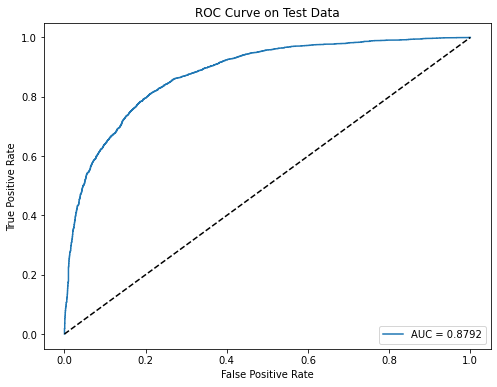

In [17]:
# Test on test set
if y_test is not None:
    # Make predictions
    y_pred = loaded_rf.predict(X_test_with_indicators)
    y_pred_proba = loaded_rf.predict_proba(X_test_with_indicators)[:, 1]  # Probability of class '1'

    # Evaluation Metrics
    print("=== Test Data Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=grid_search.best_estimator_.named_steps['classifier'].classes_[1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()
else:
    # If test_data does not contain 'nicotine12d', save predictions
    y_pred = loaded_rf.predict(X_test_with_indicators)
    y_pred_proba = loaded_rf.predict_proba(X_test_with_indicators)[:, 1]  # Probability of class '1'
    test_predictions_df = X_test.copy()
    test_predictions_df['nicotine12d_pred'] = y_pred
    test_predictions_df['nicotine12d_pred_proba'] = y_pred_proba
    test_predictions_df.to_csv('test_predictions.csv', index=False)

### RF Feature Importance

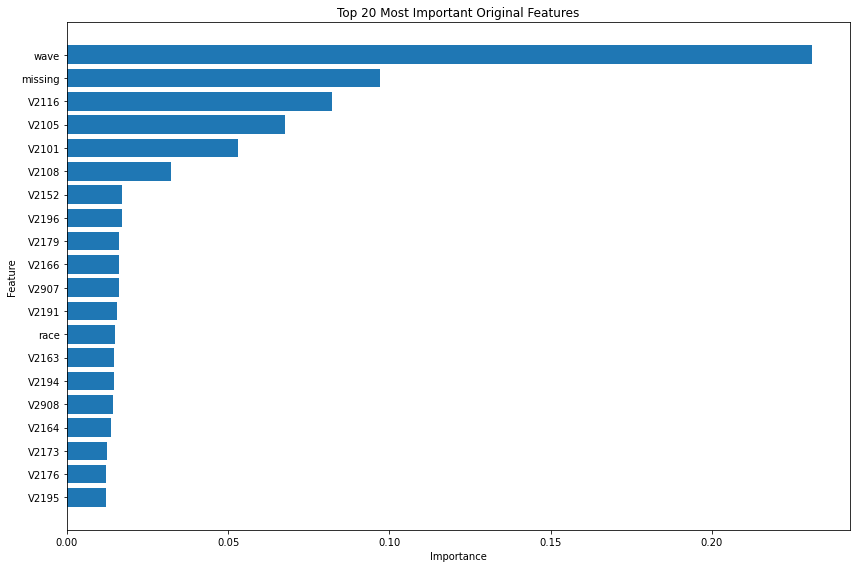


Feature Importance Rankings:
       Feature  Importance
14        wave    0.231115
58     missing    0.097136
5        V2116    0.082187
8        V2105    0.067790
43       V2101    0.052995
16       V2108    0.032190
37       V2152    0.017071
48       V2196    0.017003
39       V2179    0.016233
26       V2166    0.016073
24       V2907    0.016033
22       V2191    0.015505
47        race    0.015078
49       V2163    0.014528
17       V2194    0.014491
13       V2908    0.014433
50       V2164    0.013752
51       V2173    0.012526
20       V2176    0.012275
45       V2195    0.012038
31       V2494    0.012007
59       V2193    0.011853
15       V2033    0.011291
4        V2169    0.010227
32       V2175    0.009941
41       V2177    0.009863
21       V2184    0.009473
18         V49    0.009320
2        V2197    0.008977
10         V13    0.008537
38       V2178    0.008244
12       V2182    0.008042
25       V2183    0.007975
23       V2201    0.007188
30       V2172    0.00714

In [70]:
# Get the Random Forest classifier and importances
rf_classifier = loaded_rf.named_steps['classifier']
importances = rf_classifier.feature_importances_

# Get the OneHotEncoder
ohe = preprocessor.named_transformers_['cat']

# Get all encoded feature names
encoded_feature_names = ohe.get_feature_names_out()

# Extract original feature names from encoded features
original_features = list(set([feat.split('_')[0] for feat in encoded_feature_names]))

# Create a dictionary to store original feature importances
original_feature_importance = {}

# For each original feature
for feature in original_features:
    # Find all encoded columns that came from this feature
    encoded_features_mask = [str(name).startswith(feature + '_') for name in encoded_feature_names]
    # Sum the importances of all encoded features from this original feature
    importance = importances[encoded_features_mask].sum()
    original_feature_importance[feature] = importance

# Convert to DataFrame and sort
feature_importance_df = pd.DataFrame({
    'Feature': original_feature_importance.keys(),
    'Importance': original_feature_importance.values()
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)  # Changed to True

# Take top 20 and plot
top_20 = feature_importance_df.tail(20)  # Use tail instead of head since we sorted ascending

plt.figure(figsize=(12, 8))
plt.barh(y=top_20['Feature'], 
         width=top_20['Importance'])
plt.title('Top 20 Most Important Original Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print the DataFrame (in descending order for readability)
print("\nFeature Importance Rankings:")
print(feature_importance_df.sort_values('Importance', ascending=False))

In [ ]:
# Single feature PDP
features = [14] # Index of feature to analyze
PartialDependenceDisplay.from_estimator(loaded_rf, X_train_with_indicators, features)

<Figure size 864x576 with 0 Axes>

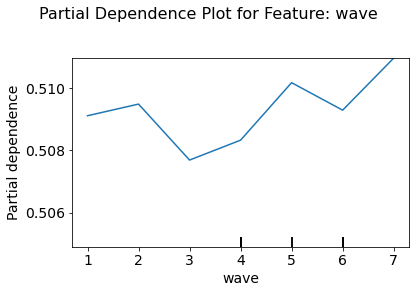

<Figure size 864x576 with 0 Axes>

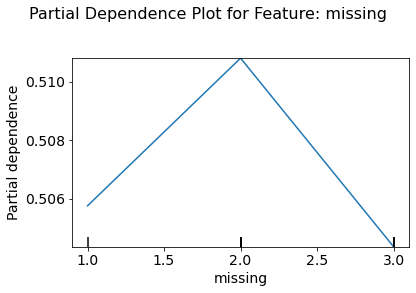

<Figure size 864x576 with 0 Axes>

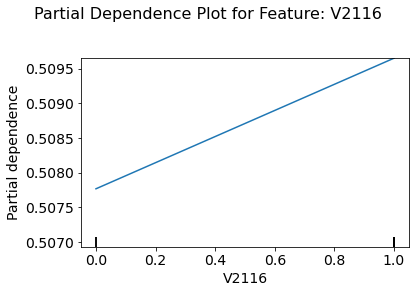

<Figure size 864x576 with 0 Axes>

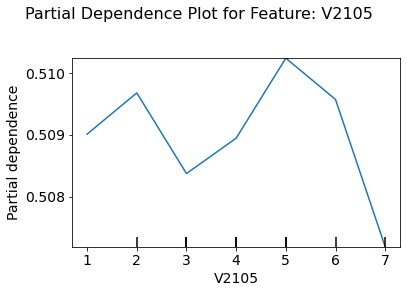

<Figure size 864x576 with 0 Axes>

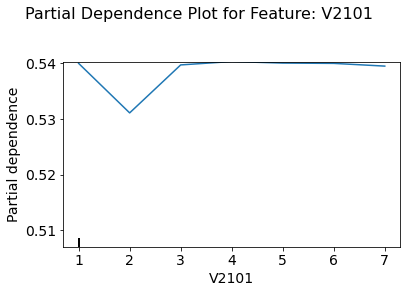

<Figure size 864x576 with 0 Axes>

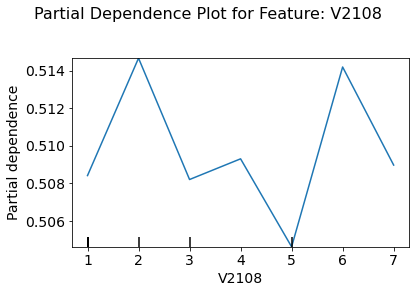

<Figure size 864x576 with 0 Axes>

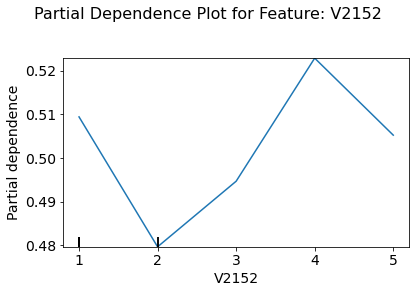

<Figure size 864x576 with 0 Axes>

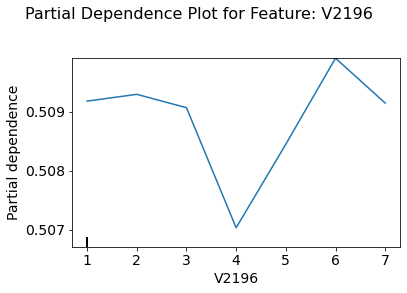

<Figure size 864x576 with 0 Axes>

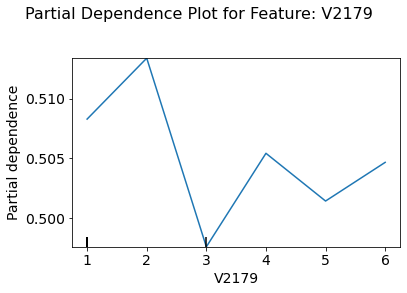

<Figure size 864x576 with 0 Axes>

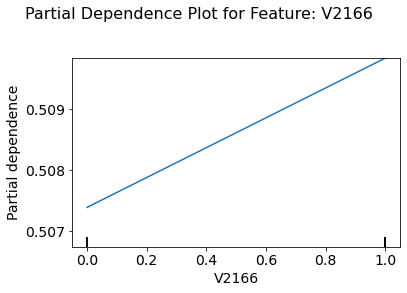

In [86]:
# Get the indices of top 10 features
top_10_indices = feature_importance_df.index[:10].tolist()
feature_names = dict(zip(feature_importance_df.index, feature_importance_df['Feature']))

# Loop through each feature and create individual PDP plots
for idx in top_10_indices:
    # Create a new figure for each plot with large size
    plt.figure(figsize=(12, 8))
    
    # Create single PDP plot
    pdp = PartialDependenceDisplay.from_estimator(
        loaded_rf, 
        X_train_with_indicators, 
        features=[idx],  # Pass single feature as a list
        feature_names=feature_names,
        random_state=42
    )
    
    # Add title for each plot
    plt.suptitle(f'Partial Dependence Plot for Feature: {feature_names[idx]}', 
                 fontsize=16, 
                 y=1.02)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show each plot
    plt.show()

## Gradient Boosting Trees

In [17]:
# Create a pipeline that first preprocesses the data and then fits the model
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=123))
])

In [ ]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_samples_split': [2, 3, 4]  # Added min_samples_split
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1 # Progress messages at the end of each fold
)

grid_search.fit(X_train_with_indicators, y_train)

In [23]:
# Best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Best cross-validation score
print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")

Best parameters found:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 150}
Best cross-validation ROC AUC: 0.9037


In [24]:
# Save the model
joblib.dump(grid_search.best_estimator_, 'gradient_boosting_tree_model.joblib')
print("Model saved to 'gradient_boosting_tree_model.joblib'.")

Model saved to 'gradient_boosting_tree_model.joblib'.


In [51]:
# Load the model (when needed)
loaded_gbt = joblib.load('gradient_boosting_tree_model.joblib')
print("Model loaded successfully.")

Model loaded successfully.


=== Test Data Evaluation ===
Confusion Matrix:
[[2772  612]
 [ 616 3050]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82      3384
         1.0       0.83      0.83      0.83      3666

    accuracy                           0.83      7050
   macro avg       0.83      0.83      0.83      7050
weighted avg       0.83      0.83      0.83      7050

ROC AUC: 0.9038


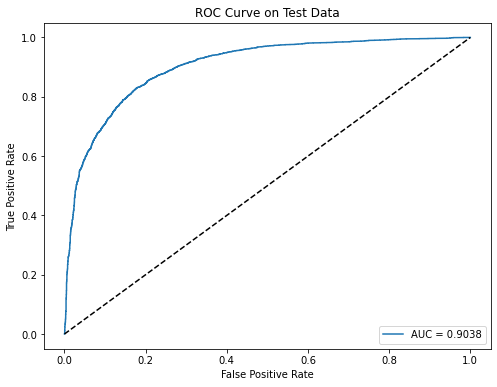

In [32]:
# Test on test set
if y_test is not None:
    # Make predictions
    y_pred = loaded_gbt.predict(X_test_with_indicators)
    y_pred_proba = loaded_gbt.predict_proba(X_test_with_indicators)[:, 1]  # Probability of class '1'

    # Evaluation Metrics
    print("=== Test Data Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=grid_search.best_estimator_.named_steps['classifier'].classes_[1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()
else:
    # If test_data does not contain 'nicotine12d', save predictions
    y_pred = loaded_gbt.predict(X_test_with_indicators)
    y_pred_proba = loaded_gbt.predict_proba(X_test_with_indicators)[:, 1]  # Probability of class '1'
    test_predictions_df = X_test.copy()
    test_predictions_df['nicotine12d_pred'] = y_pred
    test_predictions_df['nicotine12d_pred_proba'] = y_pred_proba
    test_predictions_df.to_csv('test_predictions.csv', index=False)

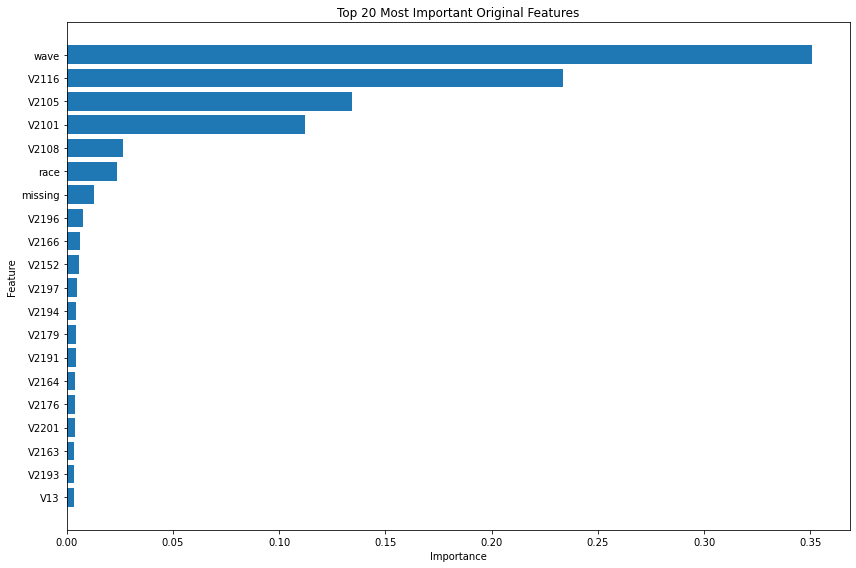


Feature Importance Rankings:
       Feature  Importance
18        wave    0.350929
51       V2116    0.233435
57       V2105    0.134139
44       V2101    0.112349
21       V2108    0.026313
19        race    0.023604
11     missing    0.012711
55       V2196    0.007640
34       V2166    0.006307
12       V2152    0.005578
20       V2197    0.004903
1        V2194    0.004477
15       V2179    0.004269
53       V2191    0.004140
56       V2164    0.003867
6        V2176    0.003857
25       V2201    0.003726
42       V2163    0.003504
24       V2193    0.003295
39         V13    0.003235
32       V2175    0.002999
52       V2178    0.002716
16       V2195    0.002673
23       V2177    0.002664
26       V2033    0.002578
47       V2172    0.002099
40       V2184    0.002025
37       V2173    0.001988
2          V49    0.001952
27         sex    0.001944
50       V2182    0.001817
22       V2183    0.001723
7        V2169    0.001593
0        V2119    0.001553
33       V2188    0.00146

In [44]:
# Get the Random Forest classifier and importances
gbt_classifier = loaded_gbt.named_steps['classifier']
importances = gbt_classifier.feature_importances_

pipeline.fit(X_train_with_indicators, y_train)

# Get the OneHotEncoder
ohe = preprocessor.named_transformers_['cat']

# Get all encoded feature names
encoded_feature_names = ohe.get_feature_names_out()

# Extract original feature names from encoded features
original_features = list(set([feat.split('_')[0] for feat in encoded_feature_names]))

# Create a dictionary to store original feature importances
original_feature_importance = {}

# For each original feature
for feature in original_features:
    # Find all encoded columns that came from this feature
    encoded_features_mask = [str(name).startswith(feature + '_') for name in encoded_feature_names]
    # Sum the importances of all encoded features from this original feature
    importance = importances[encoded_features_mask].sum()
    original_feature_importance[feature] = importance

# Convert to DataFrame and sort
feature_importance_df = pd.DataFrame({
    'Feature': original_feature_importance.keys(),
    'Importance': original_feature_importance.values()
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True)  # Changed to True

# Take top 20 and plot
top_20 = feature_importance_df.tail(20)  # Use tail instead of head since we sorted ascending

plt.figure(figsize=(12, 8))
plt.barh(y=top_20['Feature'], 
         width=top_20['Importance'])
plt.title('Top 20 Most Important Original Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print the DataFrame (in descending order for readability)
print("\nFeature Importance Rankings:")
print(feature_importance_df.sort_values('Importance', ascending=False))

<Figure size 864x576 with 0 Axes>

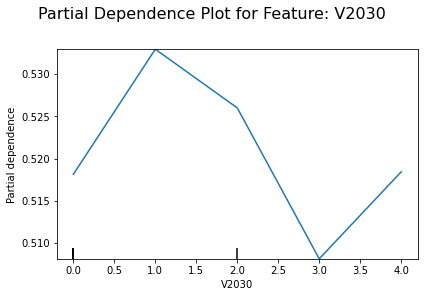

<Figure size 864x576 with 0 Axes>

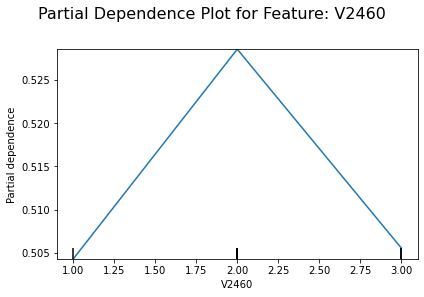

<Figure size 864x576 with 0 Axes>

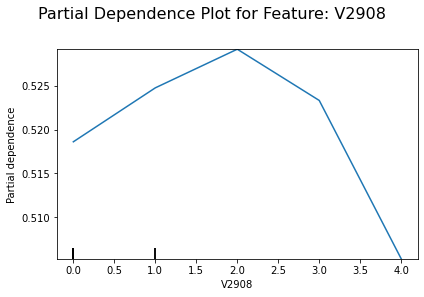

<Figure size 864x576 with 0 Axes>

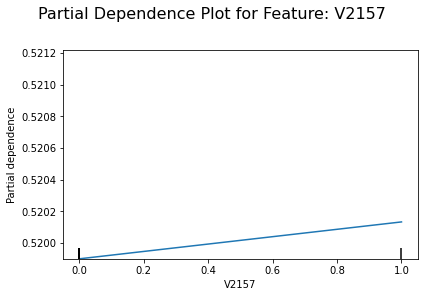

<Figure size 864x576 with 0 Axes>

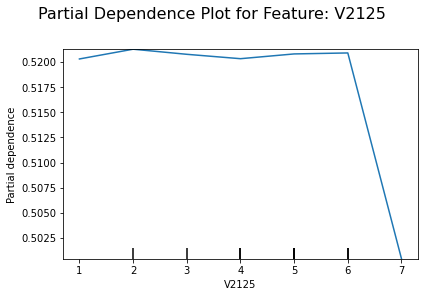

<Figure size 864x576 with 0 Axes>

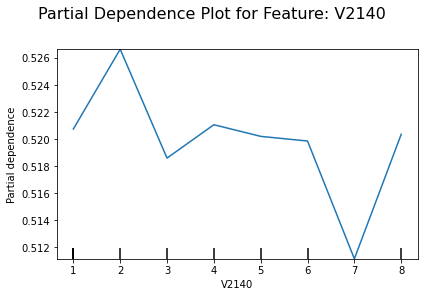

<Figure size 864x576 with 0 Axes>

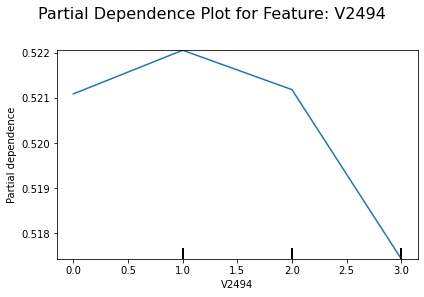

/storage/icds/RISE/sw8/anaconda/conda_envs/pyspark/lib/python3.10/site-packages/sklearn/inspection/_plot/partial_dependence.py:1110: UserWarning: Attempting to set identical bottom == top == 0.5199622194192765 results in singular transformations; automatically expanding.
  ax.set_ylim(self.pdp_lim[1])


<Figure size 864x576 with 0 Axes>

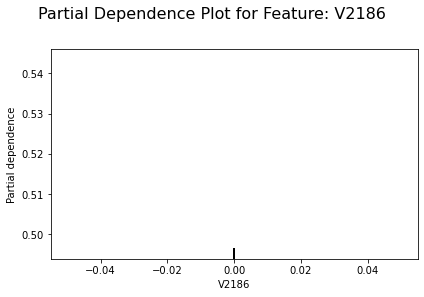

<Figure size 864x576 with 0 Axes>

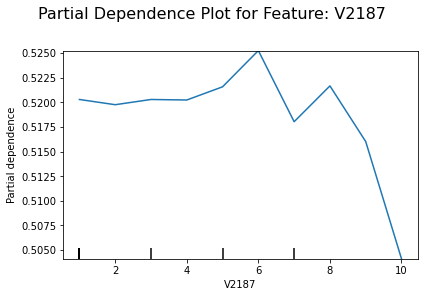

<Figure size 864x576 with 0 Axes>

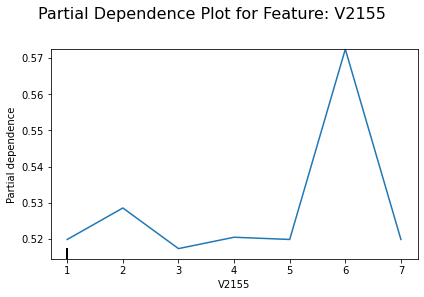

In [46]:
# Get the indices of top 10 features
top_10_indices = feature_importance_df.index[:10].tolist()
feature_names = dict(zip(feature_importance_df.index, feature_importance_df['Feature']))

# Loop through each feature and create individual PDP plots
for idx in top_10_indices:
    # Create a new figure for each plot with large size
    plt.figure(figsize=(12, 8))
    
    # Create single PDP plot
    pdp = PartialDependenceDisplay.from_estimator(
        loaded_gbt, 
        X_train_with_indicators, 
        features=[idx],  # Pass single feature as a list
        feature_names=feature_names,
        random_state=42
    )
    
    # Add title for each plot
    plt.suptitle(f'Partial Dependence Plot for Feature: {feature_names[idx]}', 
                 fontsize=16, 
                 y=1.02)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show each plot
    plt.show()

In [55]:
# Extract the GradientBoostingClassifier
gbt_model = loaded_gbt.named_steps['classifier']
# Get preprocessed features
X_preprocessed = loaded_gbt.named_steps['preprocessor'].transform(X_test_with_indicators)

In [56]:
# Now create the SHAP explainer
import shap
explainer = shap.TreeExplainer(gbt_model)
# Calculate SHAP values
shap_values = explainer.shap_values(X_preprocessed)

In [57]:
# Get feature names after preprocessing
feature_names = loaded_gbt.named_steps['preprocessor'].get_feature_names_out()

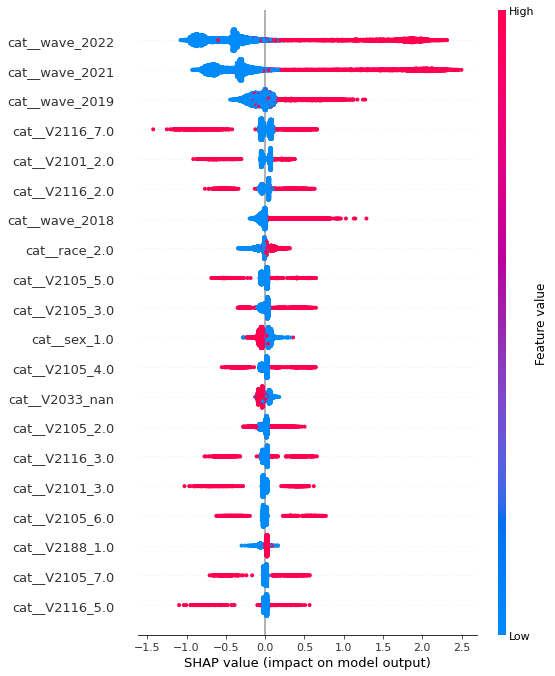

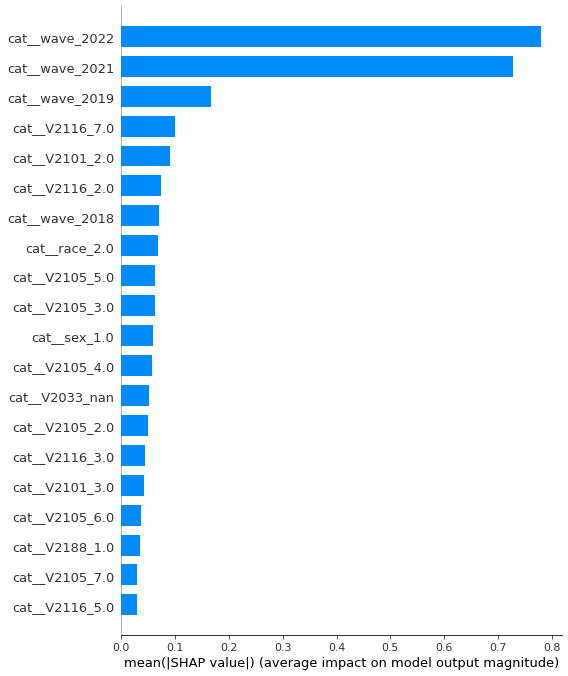

In [58]:
# Create visualizations
# Summary plot
shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names)
# Bar plot of feature importance
shap.summary_plot(shap_values, X_preprocessed, feature_names=feature_names, plot_type='bar')

In [61]:
# For individual predictions (e.g., first sample)
shap.initjs()  # Initialize JavaScript visualization
single_sample_idx = 0
shap.force_plot(explainer.expected_value[1] if isinstance(shap_values, list) else explainer.expected_value,
                shap_values[single_sample_idx] if isinstance(shap_values, list) else shap_values[single_sample_idx,:],
                X_preprocessed[single_sample_idx],
                feature_names=feature_names)

## Histogram-based Gradient Boost Classifier

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

# Define the pipeline with HistGradientBoostingClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=123))
])

In [ ]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Parameter grid for GridSearchCV
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'classifier__max_iter': [100, 200, 300],
    'classifier__max_depth': [None, 3, 5, 7],
    'classifier__l2_regularization': [0.0, 0.1, 1.0],
    'classifier__min_samples_leaf': [20, 30, 50]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1  # Print progress
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and cross-validation score
print("Best parameters found:")
print(grid_search.best_params_)

print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")

In [ ]:
# Save the model
joblib.dump(grid_search.best_estimator_, 'hist_gradient_boosting_tree_model.joblib')
print("Model saved to 'hist_gradient_boosting_tree_model.joblib'.")

# Load the model (when needed)
# loaded_model = joblib.load('random_forest_model.joblib')
# print("Model loaded successfully.")

In [ ]:
# Test on test set
if y_test is not None:
    # Make predictions
    y_pred = grid_search.predict(X_test)
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]  # Probability of class '1'

    # Evaluation Metrics
    print("=== Test Data Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=grid_search.best_estimator_.named_steps['classifier'].classes_[1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.show()
else:
    # If test_data does not contain 'nicotine12d', save predictions
    y_pred = grid_search.predict(X_test)
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]  # Probability of class '1'
    test_predictions_df = X_test.copy()
    test_predictions_df['nicotine12d_pred'] = y_pred
    test_predictions_df['nicotine12d_pred_proba'] = y_pred_proba
    test_predictions_df.to_csv('test_predictions.csv', index=False)

In [ ]:
from sklearn.inspection import permutation_importance

# Fit the pipeline on the entire training set
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Permutation feature importance
result = permutation_importance(best_model, X_train, y_train, scoring='roc_auc', n_repeats=10, random_state=123, n_jobs=-1)

# Get feature names (from preprocessor)
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe.fit(X_train[categorical_cols])
ohe_features = ohe.get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(ohe_features)

# Combine permutation importances into a DataFrame
importances = pd.DataFrame({
    'Feature': all_features,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot Top 20 Features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances.head(20))
plt.title('Top 20 Feature Importances (Permutation)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# XGBOOST

In [ ]:
pip install optuna

In [ ]:
import optuna
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import numpy as np

# Define the objective function
def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3, log=True)  # Log-scale for finer control
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 10)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 10)

    # Define the model with current trial's hyperparameters
    classifier = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=123,
        eval_metric='logloss'
    )

    # Preprocessing pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    # Compute ROC AUC using cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)

    # Return the mean of AUC scores
    return np.mean(scores)

In [ ]:
 # Create a study object
study = optuna.create_study(direction='maximize', study_name="XGBoost Optimization")

# Start optimization
study.optimize(objective, n_trials=50)  # Adjust n_trials based on computational resources

# Print the best hyperparameters and the corresponding ROC AUC
print("Best Hyperparameters:")
print(study.best_params)
print(f"Best ROC AUC: {study.best_value:.4f}")

In [ ]:
# Get best hyperparameters
best_params = study.best_params

# Create the final classifier with best hyperparameters
final_model = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=123,
    eval_metric='logloss',
    use_label_encoder=False
)

# Final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])

# Train the pipeline on the full training data
final_pipeline.fit(X_train, y_train)



In [ ]:
# Save the final model
import joblib
joblib.dump(final_pipeline, "xgboost_optimized_model.joblib")
print("Optimized model saved to 'xgboost_optimized_model.joblib'.")

In [ ]:
# Test on test set
if y_test is not None:
    # Make predictions
    y_pred = final_pipeline.predict(X_test)
    y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]  # Probability of class '1'

    # Evaluation Metrics
    print("=== Test Data Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(
        y_test, 
        y_pred_proba, 
        pos_label=final_pipeline.named_steps['classifier'].classes_[1]
    )
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Add diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
else:
    # If test_data does not contain true labels, save predictions
    y_pred = final_pipeline.predict(X_test)
    y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]  # Probability of class '1'
    
    # Create a DataFrame to save predictions
    test_predictions_df = X_test.copy()
    test_predictions_df['predicted_class'] = y_pred
    test_predictions_df['predicted_proba'] = y_pred_proba
    
    # Save the predictions to a CSV file
    test_predictions_df.to_csv('test_predictions.csv', index=False)
    print("Predictions saved to 'test_predictions.csv'.")

In [ ]:
# Ensure the pipeline is already fitted
if not hasattr(final_pipeline, "fit"):
    final_pipeline.fit(X_train, y_train)

In [ ]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(
    final_pipeline, X_test, y_test, 
    scoring='roc_auc', 
    n_repeats=10, 
    random_state=123, 
    n_jobs=-1
)

# Create a DataFrame for permutation importance
perm_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
}).sort_values(by='Importance', ascending=False)

# Display Top 20 Permutation Importance Features
print("Top 20 Features by Permutation Importance:")
print(perm_importance_df.head(20))

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=perm_importance_df.head(20)
)
plt.title('Top 20 Features by Permutation Importance')
plt.xlabel('Importance (Mean Decrease in ROC AUC)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# CatBoost

In [ ]:
# pip install catboost

In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Indices of categorical columns in the dataset
cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols]
cat_features_indices

In [ ]:
# Preprocessing: Scale numerical columns (categorical columns are handled natively by CatBoost)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'  # Keep categorical columns in their original form
)

# Define CatBoost pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocess numerical columns only
    ('classifier', CatBoostClassifier(
        cat_features=cat_features_indices,  # Specify categorical features
        silent=True,  # Suppress verbosity
        random_seed=123  # For reproducibility
    ))
])

In [ ]:
# Define hyperparameter grid
param_grid = {
    'classifier__iterations': [100, 300, 500],  # Number of boosting iterations
    'classifier__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'classifier__depth': [4, 6, 8],  # Depth of trees
    'classifier__l2_leaf_reg': [1, 3, 5],  # L2 regularization
    'classifier__border_count': [32, 64, 128],  # Number of bins for numerical features
    'classifier__subsample': [0.8, 1.0]  # Subsample ratio of rows
}

In [ ]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Optimize for ROC AUC
    n_jobs=-1,  # Use all available CPUs
    verbose=1  # Verbose output
)

# Train the model
grid_search.fit(X_train, y_train)

# Display best parameters and cross-validation score
print("Best Parameters Found:")
print(grid_search.best_params_)
print(f"Best Cross-Validation ROC AUC: {grid_search.best_score_:.4f}")

In [ ]:
# Save the final model
import joblib
joblib.dump(final_pipeline, "catboost_optimized_model.joblib")
print("Optimized model saved to 'catboost_optimized_model.joblib'.")

In [ ]:
# Test on Test Data
if y_test is not None:
    # Make predictions
    y_pred = grid_search.predict(X_test)
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]  # Probability of class '1'

    # Evaluation Metrics
    print("=== Test Data Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
else:
    # Save predictions if `y_test` is not available
    y_pred = grid_search.predict(X_test)
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
    test_predictions_df = X_test.copy()
    test_predictions_df['predicted_class'] = y_pred
    test_predictions_df['predicted_proba'] = y_pred_proba
    test_predictions_df.to_csv('catboost_test_predictions.csv', index=False)
    print("Predictions saved to 'catboost_test_predictions.csv'.")

In [ ]:
# Retrieve the best CatBoost model from the pipeline
best_catboost_model = grid_search.best_estimator_.named_steps['classifier']

# Get feature names (numerical + categorical)
all_features = numerical_cols + categorical_cols

# Extract feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': best_catboost_model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

# Display Top 20 Important Features
print("Top 20 Features by Importance:")
print(feature_importance_df.head(20))

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Features by Importance (CatBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'classifier__iterations': trial.suggest_int('iterations', 100, 1000),
        'classifier__learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'classifier__depth': trial.suggest_int('depth', 4, 10),
        'classifier__l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'classifier__border_count': trial.suggest_categorical('border_count', [32, 64, 128, 256]),
        'classifier__subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }

    pipeline.set_params(**params)
    score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best Parameters Found:")
print(study.best_params)
print(f"Best ROC AUC: {study.best_value:.4f}")


In [ ]:
import joblib
from sklearn.metrics import roc_auc_score

# Set the best parameters found by Optuna
best_params = study.best_params

# Assuming the study.best_params dictionary contains the correct names like:
# {'iterations': 500, 'learning_rate': 0.1, ...}

# Update the pipeline with the best parameters found by Optuna
pipeline.set_params(
    classifier__iterations=best_params['iterations'],
    classifier__learning_rate=best_params['learning_rate'],
    classifier__depth=best_params['depth'],
    classifier__l2_leaf_reg=best_params['l2_leaf_reg'],
    classifier__border_count=best_params['border_count'],
    classifier__subsample=best_params['subsample']
)

# Train the final model on the entire training data
pipeline.fit(X_train, y_train)

# Step 2: Save the model using joblib
import joblib
joblib.dump(pipeline, 'catboost_model.pkl')
print("Model saved successfully!")

In [ ]:
# Test on Test Data
if y_test is not None:
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability of class '1'

    # Evaluation Metrics
    print("=== Test Data Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
else:
    # Save predictions if `y_test` is not available
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    test_predictions_df = X_test.copy()
    test_predictions_df['predicted_class'] = y_pred
    test_predictions_df['predicted_proba'] = y_pred_proba
    test_predictions_df.to_csv('catboost_test_predictions.csv', index=False)
    print("Predictions saved to 'catboost_test_predictions.csv'.")

In [ ]:
# Get the top 30 features
top_30_features = feature_importance_df.head(30)['Feature'].tolist()

# Display the top 30 features
print("Top 30 Features by Importance:")
print(top_30_features)


In [ ]:
# Select the top 30 features from X_train and X_test
X_train_selected = X_train[top_30_features]
X_test_selected = X_test[top_30_features]

# Save X_train_selected to a pickle file
X_train_selected.to_pickle('X_train_selected.pkl')

# Save X_test_selected to a pickle file
X_test_selected.to_pickle('X_test_selected.pkl')


In [ ]:
import pandas as pd
# Load X_train_selected from the pickle file
X_train_selected = pd.read_pickle('X_train_selected.pkl')

# Load X_test_selected from the pickle file
X_test_selected = pd.read_pickle('X_test_selected.pkl')

# Check the first few rows of each DataFrame to verify the load
print(X_train_selected.head())
print(X_test_selected.head())

In [ ]:
X_train_selected.dtypes

In [ ]:
# Indices of categorical columns in the dataset
cat_features_indices_s = [X_train.columns.get_loc(col) for col in categorical_cols]
cat_features_indices_s

# Identify numerical columns
numerical_cols = X_train_selected.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
# Preprocessing: Scale numerical columns (categorical columns are handled natively by CatBoost)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'  # Keep categorical columns in their original form
)

# Define CatBoost pipeline
pipeline1 = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocess numerical columns only
    ('classifier', CatBoostClassifier(
        cat_features=cat_features_indices_s,  # Specify categorical features
        silent=True,  # Suppress verbosity
        random_seed=123  # For reproducibility
    ))
])

In [ ]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# Perform GridSearchCV
grid_search_s = GridSearchCV(
    estimator=pipeline1,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Optimize for ROC AUC
    n_jobs=-1,  # Use all available CPUs
    verbose=1  # Verbose output
)

# Train the model
grid_search_s.fit(X_train_selected, y_train)



In [ ]:
# Display best parameters and cross-validation score
print("Best Parameters Found:")
print(grid_search_s.best_params_)
print(f"Best Cross-Validation ROC AUC: {grid_search_s.best_score_:.4f}")

In [ ]:
#Test on Test Data
if y_test is not None:
    # Make predictions
    y_pred = grid_search_s.predict(X_test)
    y_pred_proba = grid_search_s.predict_proba(X_test)[:, 1]  # Probability of class '1'

    # Evaluation Metrics
    print("=== Test Data Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Test Data')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
else:
    # Save predictions if `y_test` is not available
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    test_predictions_df = X_test.copy()
    test_predictions_df['predicted_class'] = y_pred
    test_predictions_df['predicted_proba'] = y_pred_proba
    test_predictions_df.to_csv('catboost_test_predictions.csv', index=False)
    print("Predictions saved to 'catboost_test_predictions.csv'.")